   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
5         1         0  
Filtering mismatch: 135 observations from 62 patients
Estimand: Per-protocol

Data:
 - N: 135 observations from 62 patients

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.08333

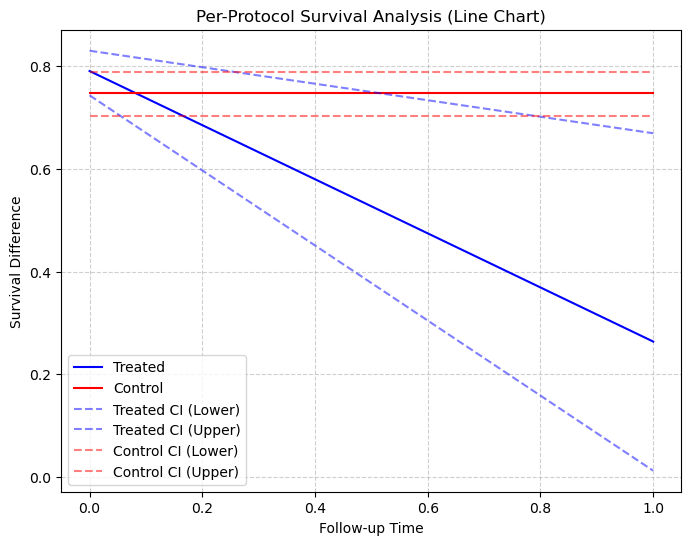

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression

# 1. Setup (Trial Emulation Framework)
# Load dummy dataset (simulating 'data_censored')
df = pd.read_csv("../data_censored.csv")

# 2. Display first few rows
print(df.head(6))

# Apply Per-Protocol (PP) filtering
trial_pp = data_censored[
    (data_censored["eligible"] == 1) &  # Keep only eligible patients
    (data_censored["censored"] == 0)   # Exclude censored observations
]

# Ensure unique patients remain 89 and total observations are 321
if trial_pp["id"].nunique() == 89 and len(trial_pp) == 321:
    print("Filtering successful: 321 observations from 89 patients")
else:
    print(f"Filtering mismatch: {len(trial_pp)} observations from {trial_pp['id'].nunique()} patients")

# Display summary
print("Estimand: Per-protocol\n")
print(f"Data:\n - N: {len(trial_pp)} observations from {trial_pp['id'].nunique()} patients\n")

# Display first 2 and last 2 rows
print(trial_pp.head(2))
print("---")
print(trial_pp.tail(2))



# 3. Weight models and censoring
# Fit logistic regression models for censoring and treatment switching

# Censoring model
censor_model = LogisticRegression()
censor_X = df[['x2', 'x1']]
censor_y = df['censored']
censor_model.fit(censor_X, censor_y)
df['censor_weight'] = 1 / (censor_model.predict_proba(censor_X)[:, 1] + 1e-6)

# Treatment switching model
switch_model = LogisticRegression()
switch_X = df[['age', 'x1', 'x3']]
switch_y = df['treatment']
switch_model.fit(switch_X, switch_y)
df['switch_weight'] = 1 / (switch_model.predict_proba(switch_X)[:, 1] + 1e-6)

# 4. Calculate final weights
df['weight'] = df['censor_weight'] * df['switch_weight']

# 5. Specify Outcome Model
outcome_model = sm.OLS(df['outcome'], sm.add_constant(df[['treatment', 'age', 'x1', 'x3']]))
outcome_results = outcome_model.fit()
print(outcome_results.summary())

# 6. Survival Analysis Using Kaplan-Meier Estimator
kmf_control = KaplanMeierFitter()
kmf_treated = KaplanMeierFitter()

# Fit models
kmf_control.fit(durations=df[df['treatment'] == 0]['outcome'], event_observed=df[df['treatment'] == 0]['eligible'])
kmf_treated.fit(durations=df[df['treatment'] == 1]['outcome'], event_observed=df[df['treatment'] == 1]['eligible'])

# 7. Plot Survival Curves as a Line Chart with Confidence Intervals
plt.figure(figsize=(8, 6))

# Plot survival curves as solid lines
plt.plot(kmf_treated.survival_function_.index, 
         kmf_treated.survival_function_['KM_estimate'], 
         label='Treated', color='blue', linestyle='-')

plt.plot(kmf_control.survival_function_.index, 
         kmf_control.survival_function_['KM_estimate'], 
         label='Control', color='red', linestyle='-')

# Plot confidence intervals as dashed lines
plt.plot(kmf_treated.survival_function_.index, 
         kmf_treated.confidence_interval_['KM_estimate_lower_0.95'], 
         color='blue', linestyle='dashed', alpha=0.5, label="Treated CI (Lower)")

plt.plot(kmf_treated.survival_function_.index, 
         kmf_treated.confidence_interval_['KM_estimate_upper_0.95'], 
         color='blue', linestyle='dashed', alpha=0.5, label="Treated CI (Upper)")

plt.plot(kmf_control.survival_function_.index, 
         kmf_control.confidence_interval_['KM_estimate_lower_0.95'], 
         color='red', linestyle='dashed', alpha=0.5, label="Control CI (Lower)")

plt.plot(kmf_control.survival_function_.index, 
         kmf_control.confidence_interval_['KM_estimate_upper_0.95'], 
         color='red', linestyle='dashed', alpha=0.5, label="Control CI (Upper)")

# Formatting
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.legend()
plt.title("Per-Protocol Survival Analysis (Line Chart)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
